In [1]:
using Pkg
Pkg.activate(".")

  Activating project at `~/code/phasor_julia`


In [2]:
include("module.jl")
using .PhasorNetworks

In [3]:
using Plots

In [4]:
using LinearAlgebra: triu, diagm, diag

In [94]:
using Statistics: std, median

In [6]:
using QuadGK

# Construct a random graph

In [7]:
function generate_er_graph(n::Int, p::Real, self_loops::Bool = false)
    adj = rand(Float64, (n, n)) .< p
    #make undirected
    adj = triu(adj)
    adj =  (adj .+ adj') .> 0

    if !self_loops
        #remove self-loops
        for i in 1:n
            adj[i,i] = 0
        end
    end

    return adj
end

generate_er_graph (generic function with 2 methods)

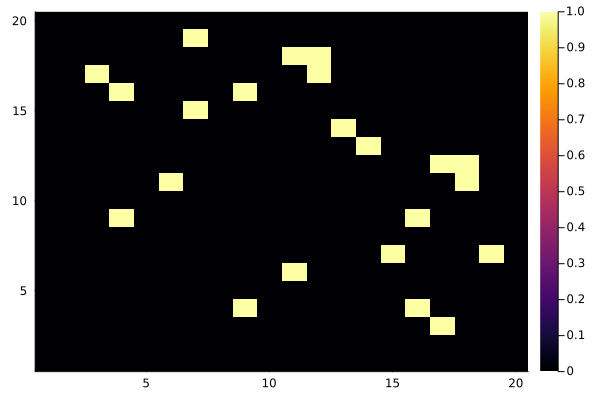

In [14]:
g1 = generate_er_graph(20, 0.1)
heatmap(g1)

# Embed it into an HD vector

In [56]:
function define_node_symbols(graph::AbstractMatrix, nd::Int)
    @assert size(graph,1) == size(graph,2) "Takes an adjacency matrix as the input"
    n = size(graph,1)

    #create vectors representing the nodes
    node_values = random_symbols((n, nd))
    return node_values
end

define_node_symbols (generic function with 1 method)

In [68]:
nv1 = define_node_symbols(g1, 1024);

In [69]:
size(nv1)

(20, 1024)

In [70]:
function graph_to_vector(graph::AbstractMatrix, node_values::AbstractMatrix, nd::Int)
    @assert size(graph,1) == size(graph,2) "Takes an adjacency matrix as the input"
    n = size(graph,1)

    #get cartesian coordinates representing each edge
    edges = findall(graph)
    n_edges = length(edges)
    edge_values = zeros(Float64, n_edges, nd)

    #iterate through the edges
    for (i, edge) in enumerate(edges)
        tx = edge[1]
        rx = edge[2]

        tx_symbol = node_values[tx,:]
        rx_symbol = node_values[rx,:]
        #create a representation for that edge by binding its incident nodes
        edge_symbol = PhasorNetworks.bind(tx_symbol, rx_symbol)
        edge_values[i,:] = edge_symbol
    end

    #combine the edges in the graph to the single embedding via bundling
    graph_embedding = bundle(edge_values, dims=1)
    return graph_embedding
end

graph_to_vector (generic function with 6 methods)

In [71]:
gv1 = graph_to_vector(g1, nv1, 1024)

1×1024 Matrix{Float64}:
 0.64928  0.0979311  -0.0117098  0.697279  …  0.0385596  -0.377202  -0.991697

In [72]:
sa = default_spk_args()

Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.02 (V)


In [121]:
function graph_to_vector(graph::AbstractMatrix, node_values::AbstractMatrix, nd::Int, spk_args::SpikingArgs, repeats::Int=3)
    @assert size(graph,1) == size(graph,2) "Takes an adjacency matrix as the input"
    n = size(graph,1)
    
    #slice each node symbol into a spike train
    train_values = [phase_to_train(reshape(node, (1,:)), spk_args, repeats=repeats) for node in eachslice(node_values, dims=1)]
    tspan = (0.0, repeats * 1.0)
    
    #get cartesian coordinates representing each edge
    edges = findall(graph)
    n_edges = length(edges)
    edge_values = []

    #iterate through the edges
    function edge_to_train(edge)
        tx = edge[1]
        rx = edge[2]

        tx_symbol = train_values[tx]
        rx_symbol = train_values[rx]
        #create a representation for that edge by binding its incident nodes
        edge_symbol = PhasorNetworks.bind(tx_symbol, rx_symbol, spk_args=spk_args, tspan=tspan)
        return edge_symbol
    end

    edge_values = map(edge_to_train, edges)
    #combine the edges in the graph to the single embedding via bundling
    combined = vcat_trains(edge_values)
    graph_embedding = bundle(combined, dims=1, spk_args=spk_args, tspan=tspan)
    return train_values, graph_embedding, tspan
end

graph_to_vector (generic function with 6 methods)

In [122]:
nvt1, gvt1, tspan = graph_to_vector(g1, nv1, 1024, sa)

(SpikeTrain[Spike Train: (1, 1024) with 3072 spikes., Spike Train: (1, 1024) with 3072 spikes., Spike Train: (1, 1024) with 3072 spikes., Spike Train: (1, 1024) with 3072 spikes., Spike Train: (1, 1024) with 3072 spikes., Spike Train: (1, 1024) with 3072 spikes., Spike Train: (1, 1024) with 3072 spikes., Spike Train: (1, 1024) with 3072 spikes., Spike Train: (1, 1024) with 3072 spikes., Spike Train: (1, 1024) with 3072 spikes., Spike Train: (1, 1024) with 3072 spikes., Spike Train: (1, 1024) with 3072 spikes., Spike Train: (1, 1024) with 3072 spikes., Spike Train: (1, 1024) with 3072 spikes., Spike Train: (1, 1024) with 3072 spikes., Spike Train: (1, 1024) with 3072 spikes., Spike Train: (1, 1024) with 3072 spikes., Spike Train: (1, 1024) with 3072 spikes., Spike Train: (1, 1024) with 3072 spikes., Spike Train: (1, 1024) with 3072 spikes.], Spike Train: (1, 1024) with 3934 spikes., (0.0, 3.0))

In [123]:
nvt1[2]

Spike Train: (1, 1024) with 3072 spikes.

In [124]:
gvt1

Spike Train: (1, 1024) with 3934 spikes.

In [126]:
gv1

1×1024 Matrix{Float64}:
 0.64928  0.0979311  -0.0117098  0.697279  …  0.0385596  -0.377202  -0.991697

In [127]:
phases[2,1:1,:]

1×1024 Matrix{Float64}:
 0.7  0.26  0.02  0.76  0.2  0.74  …  0.92  0.94  0.78  0.08  0.62  0.94

In [128]:
ss = similarity(gv1, zero_nans(phases[2,1:1,:]))

1×1024 Matrix{Float64}:
 0.987332  0.873157  0.995042  0.980649  …  0.991537  -0.999961  0.977066

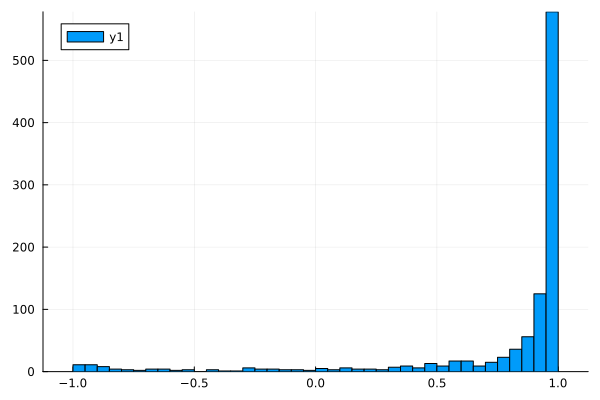

In [131]:
histogram(ss |> vec)

In [132]:
median(ss)

0.9650193331277945

# Use similarity to reconstruct the graph

In [133]:
function query_edges(graph::AbstractMatrix, nodes::AbstractMatrix)
    n = size(nodes, 1)
    nd = size(graph, 2)

    adj_rec = zeros(Float64, n, n)
    for (i,node) in enumerate(eachslice(nodes, dims=1))
        #add a dimension for consistency
        node = reshape(node, (1, :))
        query = unbind(graph, node)
        s = similarity_outer(query, nodes, dims=1) |> vec
        adj_rec[i,:] = s
    end

    return adj_rec
end

query_edges (generic function with 2 methods)

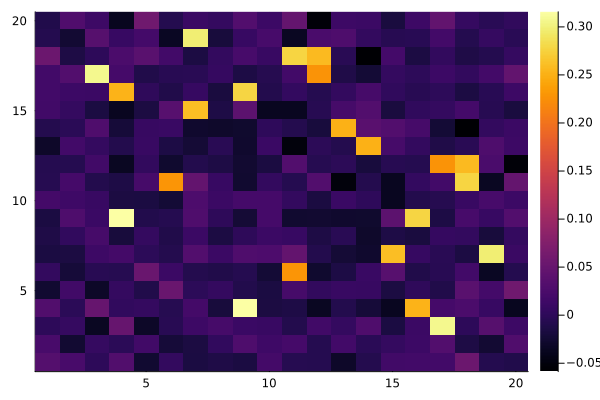

In [136]:
rec1 = query_edges(gv1, nv1)
heatmap(rec1)

In [142]:
function query_edges(graph::SpikeTrain, nodes::Vector{<:SpikeTrain}, spk_args::SpikingArgs, tspan::Tuple{<:Real, <:Real})

    all_nodes = vcat_trains(nodes)
    function query_edge(node)
        query = unbind(graph, node, tspan=tspan, spk_args=spk_args)
        s = similarity_outer(query, all_nodes, dims=1, tspan=tspan, spk_args=spk_args)
        return s
    end
    
    return map(query_edge, nodes)

    return adj_rec
end

query_edges (generic function with 2 methods)

In [156]:
anvt1 = vcat_trains(nvt1)

Spike Train: (20, 1024) with 61440 spikes.

In [157]:
q = unbind(gvt1, nvt1[1], spk_args=sa, tspan=tspan)

Spike Train: (1, 1024) with 2103 spikes.

In [166]:
gvt1.offset

0.5

In [167]:
qs = similarity_outer(q, delay_train(anvt1, 0.5), dims=1, spk_args=sa, tspan=tspan)

1×301×1×20 Array{Float64, 4}:
[:, :, 1, 1] =
 -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  …  -0.0113737  -0.0102875  -0.00799305

[:, :, 1, 2] =
 -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  …  -0.501465  -0.501465  -0.501465

[:, :, 1, 3] =
 -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  …  -0.501465  -0.501465  -0.501465

;;;; … 

[:, :, 1, 18] =
 -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  …  -0.501465  -0.501465  -0.501465

[:, :, 1, 19] =
 -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  …  -0.501465  -0.501465  -0.501465

[:, :, 1, 20] =
 -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  …  -0.501465  -0.501465  -0.501465

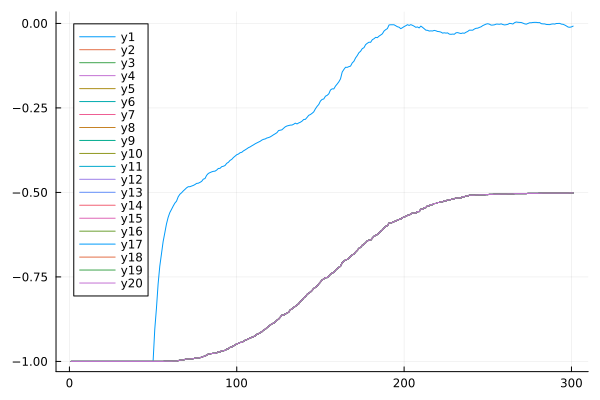

In [170]:
plot(qs[1,:,1,:])

In [168]:
qs[1,end,1,:]

20-element Vector{Float64}:
 -0.007993045235295353
 -0.5014648548094556
 -0.5014648548094556
 -0.5014648548094556
 -0.5014648548094556
 -0.5014648548094556
 -0.5014648548094556
 -0.5014648548094556
 -0.5014648548094556
 -0.5014648548094556
 -0.5014648548094556
 -0.5014648548094556
 -0.5014648548094556
 -0.5014648548094556
 -0.5014648548094556
 -0.5014648548094556
 -0.5014648548094556
 -0.5014648548094556
 -0.5014648548094556
 -0.5014648548094556

In [143]:
r = query_edges(gvt1, nvt1, sa, tspan)

20-element Vector{Array{Float64, 4}}:
 [-1.0 -0.9052734375 … 0.006100566361174065 0.00781969004350586;;;; -1.0 -1.0 … -0.5014648528886027 -0.5014648548094556;;;; -1.0 -1.0 … -0.5014648528886027 -0.5014648548094556;;;; … ;;;; -1.0 -1.0 … -0.5014648528886027 -0.5014648548094556;;;; -1.0 -1.0 … -0.5014648528886027 -0.5014648548094556;;;; -1.0 -1.0 … -0.5014648528886027 -0.5014648548094556]
 [-1.0 -0.9052734375 … 0.00035541180372473594 -0.0012793447186339822;;;; -1.0 -1.0 … -0.5004882896901107 -0.5004882893990723;;;; -1.0 -1.0 … -0.5004882896901107 -0.5004882893990723;;;; … ;;;; -1.0 -1.0 … -0.5004882896901107 -0.5004882893990723;;;; -1.0 -1.0 … -0.5004882896901107 -0.5004882893990723;;;; -1.0 -1.0 … -0.5004882896901107 -0.5004882893990723]
 [-1.0 -0.9052734375 … -0.021025594394106478 -0.02248665841991713;;;; -1.0 -1.0 … -0.5000000068102962 -0.5000000081490724;;;; -1.0 -1.0 … -0.5000000068102962 -0.5000000081490724;;;; … ;;;; -1.0 -1.0 … -0.5000000068102962 -0.5000000081490724;;;; -1.0 -1.

In [155]:
r[end][1,end,1,:]

20-element Vector{Float64}:
  0.02203918642658643
 -0.5000000101863405
 -0.5000000101863405
 -0.5000000101863405
 -0.5000000101863405
 -0.5000000101863405
 -0.5000000101863405
 -0.5000000101863405
 -0.5000000101863405
 -0.5000000101863405
 -0.5000000101863405
 -0.5000000101863405
 -0.5000000101863405
 -0.5000000101863405
 -0.5000000101863405
 -0.5000000101863405
 -0.5000000101863405
 -0.5000000101863405
 -0.5000000101863405
 -0.5000000101863405

In [150]:
osf = stack([rr[1,end,1,:] for rr in r])

20×20 Matrix{Float64}:
  0.00781969  -0.00127934  -0.0224867  …  -0.0152242  -0.0241741   0.0220392
 -0.501465    -0.500488    -0.5           -0.501465   -0.500488   -0.5
 -0.501465    -0.500488    -0.5           -0.501465   -0.500488   -0.5
 -0.501465    -0.500488    -0.5           -0.501465   -0.500488   -0.5
 -0.501465    -0.500488    -0.5           -0.501465   -0.500488   -0.5
 -0.501465    -0.500488    -0.5        …  -0.501465   -0.500488   -0.5
 -0.501465    -0.500488    -0.5           -0.501465   -0.500488   -0.5
 -0.501465    -0.500488    -0.5           -0.501465   -0.500488   -0.5
 -0.501465    -0.500488    -0.5           -0.501465   -0.500488   -0.5
 -0.501465    -0.500488    -0.5           -0.501465   -0.500488   -0.5
 -0.501465    -0.500488    -0.5        …  -0.501465   -0.500488   -0.5
 -0.501465    -0.500488    -0.5           -0.501465   -0.500488   -0.5
 -0.501465    -0.500488    -0.5           -0.501465   -0.500488   -0.5
 -0.501465    -0.500488    -0.5           -0.501

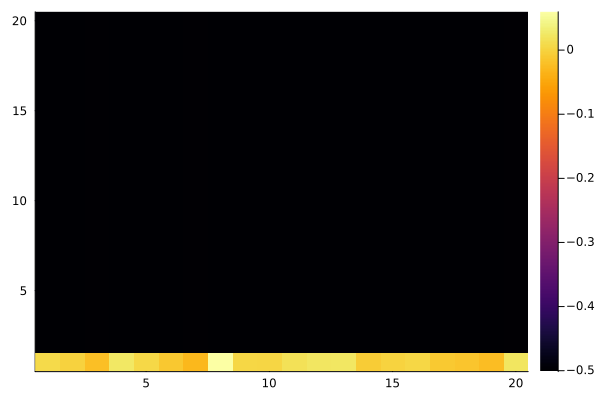

In [151]:
heatmap(osf)

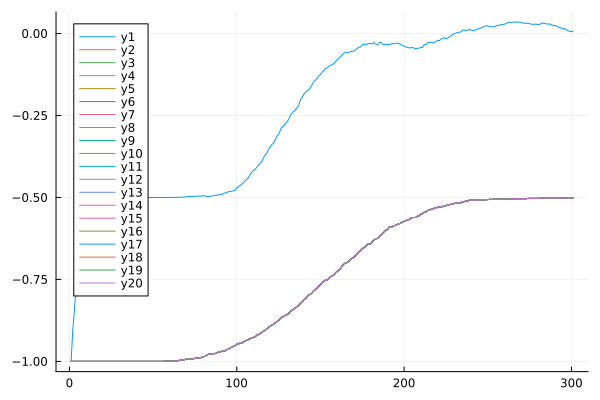

In [147]:
plot(r[1][1,:,1,:])

In [145]:
r[1][1,end,1,:]

20-element Vector{Float64}:
  0.00781969004350586
 -0.5014648548094556
 -0.5014648548094556
 -0.5014648548094556
 -0.5014648548094556
 -0.5014648548094556
 -0.5014648548094556
 -0.5014648548094556
 -0.5014648548094556
 -0.5014648548094556
 -0.5014648548094556
 -0.5014648548094556
 -0.5014648548094556
 -0.5014648548094556
 -0.5014648548094556
 -0.5014648548094556
 -0.5014648548094556
 -0.5014648548094556
 -0.5014648548094556
 -0.5014648548094556

# Reconstruct the graph with oscillator operations

In [ ]:
function query_edges_osc(graph::AbstractMatrix, nodes::AbstractMatrix)
    n = size(nodes, 1)
    nd = size(graph, 2)

    adj_rec = zeros(Float64, n, n)
    for (i,node) in enumerate(eachslice(nodes, dims=1))
        #add a dimension for consistency
        node = reshape(node, (1, :))
        query = unbind(graph, node)
        s = similarity_outer(query, nodes, dims=1) |> vec
        adj_rec[i,:] = s
    end

    return adj_rec
end

query_edges (generic function with 1 method)

# Determine the quality of the reconstruction (AUROC)

In [16]:
tpr, fpr = tpr_fpr(vec(rec1), vec(g1))

([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0])

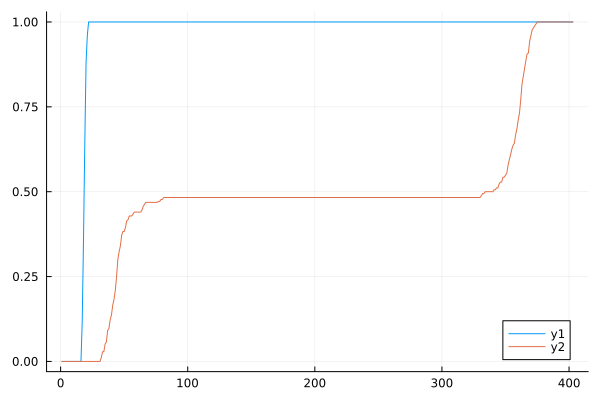

In [25]:
plot(tpr)
plot!(fpr)

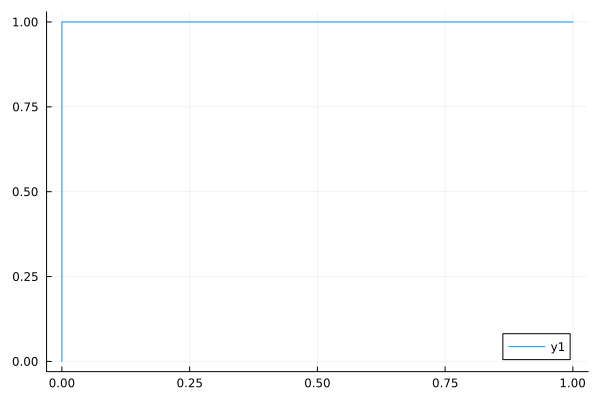

In [19]:
plot(fpr, tpr)

In [23]:
roc = interpolate_roc((tpr, fpr));

In [24]:
quadgk(x -> roc(x), 0.0, 1.0)

(1.0, 0.0)

# Run an experiment over multiple graphs